## 1. Data Exploration

In [52]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
seed = 42
rng = np.random.RandomState(seed)

In [4]:
data = pd.read_csv('../datasets/facial_keypoint_identification/facial_keypoint_identification.csv')

In [5]:
data.head()

,image_name,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,0.jpg,66,39,30,36
1,1.jpg,64,34,29,33
2,2.jpg,65,34,30,34
3,3.jpg,65,37,32,37
4,4.jpg,66,39,32,38


Shape of original image is (96, 96, 3)


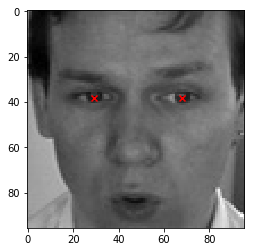

In [6]:
# get random index of data
idx = rng.choice(data.index)

# read image
img = plt.imread('../datasets/facial_keypoint_identification/images/' + data.image_name.iloc[idx])

# create an empty figure to plot the image and target
fig = plt.figure()

# plot image
plt.imshow(img)

# plot target
plt.scatter(data.left_eye_center_x.iloc[idx], data.left_eye_center_y.iloc[idx], marker='x', c='r')
plt.scatter(data.right_eye_center_x.iloc[idx], data.right_eye_center_y.iloc[idx], marker='x', c='r')

# and print the shape of image
print('Shape of original image is', img.shape)

# finally show the figure
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

In [60]:
error_left_x = mean_squared_error(data.left_eye_center_x.values, np.full(data.left_eye_center_x.values.shape, data.left_eye_center_x.mean()))
error_left_y = mean_squared_error(data.left_eye_center_y.values, np.full(data.left_eye_center_y.values.shape, data.left_eye_center_y.mean()))
error_right_x = mean_squared_error(data.right_eye_center_x.values, np.full(data.right_eye_center_x.values.shape, data.right_eye_center_x.mean()))
error_right_y = mean_squared_error(data.right_eye_center_y.values, np.full(data.right_eye_center_y.values.shape, data.right_eye_center_y.mean()))

error = (error_left_x*error_left_x + error_left_y*error_left_y + error_right_x*error_right_x + error_right_y*error_right_y ) / 4
error

104.5789947402131

## 2. Data Loading and Preprocessing

In [10]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [11]:
images = []
for img in data.image_name:
    img = image.load_img('../datasets/facial_keypoint_identification/images/' + img, target_size=(224, 224, 3))
    img = image.img_to_array(img)
    images.append(img)
    
images=np.array(images)

In [54]:
images.shape

(7033, 224, 224, 3)

In [13]:
X=preprocess_input(images, mode='tf')
y = data.iloc[:, 1:].values

In [14]:
X_train, X_valid, Y_train, Y_valid=train_test_split(X,y,test_size=0.3, random_state=42)

## 3. Model Building

In [55]:
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, InputLayer
from keras.callbacks import EarlyStopping

In [16]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [18]:
features_train = base_model.predict(X_train)
features_valid = base_model.predict(X_valid)

In [20]:
features_train.max()

10.810992

In [21]:
max_val = features_train.max()

In [22]:
features_train /= max_val
features_valid /= max_val

In [24]:
features_train = features_train.reshape(features_train.shape[0], 7*7*512)
features_valid = features_valid.reshape(features_valid.shape[0], 7*7*512)

In [61]:
model=Sequential()
model.add(InputLayer((7*7*512, )))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=4, activation='linear'))

adam = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=adam)

In [62]:
estop = EarlyStopping(patience=10, mode='min', min_delta=0.001, monitor='val_loss')

In [63]:
model.fit(features_train, Y_train, epochs=200, batch_size=512, callbacks=[estop] ,validation_data=(features_valid,Y_valid))

Train on 4923 samples, validate on 2110 samples
Epoch 1/200
4923/4923 [==============================] - 1s 207us/step - loss: 1191.2755 - mean_squared_error: 1191.2755 - val_loss: 180.5864 - val_mean_squared_error: 180.5864
Epoch 2/200
4923/4923 [==============================] - 0s 98us/step - loss: 152.2944 - mean_squared_error: 152.2944 - val_loss: 187.9358 - val_mean_squared_error: 187.9358
Epoch 3/200
4923/4923 [==============================] - 0s 98us/step - loss: 95.3501 - mean_squared_error: 95.3501 - val_loss: 55.3421 - val_mean_squared_error: 55.3421
Epoch 4/200
4923/4923 [==============================] - 0s 98us/step - loss: 59.3695 - mean_squared_error: 59.3695 - val_loss: 36.7566 - val_mean_squared_error: 36.7566
Epoch 5/200
4923/4923 [==============================] - 0s 98us/step - loss: 35.6869 - mean_squared_error: 35.6869 - val_loss: 24.9966 - val_mean_squared_error: 24.9966
Epoch 6/200
4923/4923 [==============================] - 0s 99us/step - loss: 28.5819 - mea

4923/4923 [==============================] - 0s 96us/step - loss: 5.2549 - mean_squared_error: 5.2549 - val_loss: 5.0204 - val_mean_squared_error: 5.0204
Epoch 99/200
4923/4923 [==============================] - 0s 98us/step - loss: 5.2464 - mean_squared_error: 5.2464 - val_loss: 5.1488 - val_mean_squared_error: 5.1488
Epoch 100/200
4923/4923 [==============================] - 0s 97us/step - loss: 5.1925 - mean_squared_error: 5.1925 - val_loss: 4.9961 - val_mean_squared_error: 4.9961
Epoch 101/200
4923/4923 [==============================] - 0s 95us/step - loss: 5.2611 - mean_squared_error: 5.2611 - val_loss: 4.9894 - val_mean_squared_error: 4.9894
Epoch 102/200
4923/4923 [==============================] - 0s 96us/step - loss: 5.1996 - mean_squared_error: 5.1996 - val_loss: 5.0340 - val_mean_squared_error: 5.0340
Epoch 103/200
4923/4923 [==============================] - 0s 95us/step - loss: 5.1531 - mean_squared_error: 5.1531 - val_loss: 4.9671 - val_mean_squared_error: 4.9671
Epoch 1

Epoch 147/200
4923/4923 [==============================] - 0s 98us/step - loss: 4.2504 - mean_squared_error: 4.2504 - val_loss: 4.7714 - val_mean_squared_error: 4.7714
Epoch 148/200
4923/4923 [==============================] - 0s 96us/step - loss: 4.1122 - mean_squared_error: 4.1122 - val_loss: 4.8154 - val_mean_squared_error: 4.8154
Epoch 149/200
4923/4923 [==============================] - 0s 98us/step - loss: 4.2028 - mean_squared_error: 4.2028 - val_loss: 4.8025 - val_mean_squared_error: 4.8025
Epoch 150/200
4923/4923 [==============================] - 0s 97us/step - loss: 4.1800 - mean_squared_error: 4.1800 - val_loss: 4.7710 - val_mean_squared_error: 4.7710
Epoch 151/200
4923/4923 [==============================] - 0s 97us/step - loss: 4.1690 - mean_squared_error: 4.1690 - val_loss: 4.7603 - val_mean_squared_error: 4.7603
Epoch 152/200
4923/4923 [==============================] - 0s 97us/step - loss: 4.0337 - mean_squared_error: 4.0337 - val_loss: 4.9131 - val_mean_squared_error:

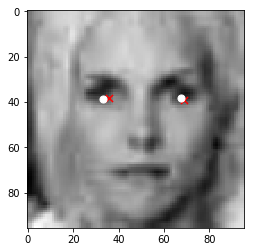

In [65]:
# get predictions
predictions = model.predict(features_valid)

# extract validation images
_, valid_images, _, _ = train_test_split(data.image_name,y,test_size=0.3, random_state=42)

# get random validation image index
idx = rng.choice(range(len(valid_images)))

# get the corresponding image name
image_name = valid_images.iloc[idx]

# get the actual targets
left_eye_center_x = data.loc[data.image_name == image_name, 'left_eye_center_x']
left_eye_center_y = data.loc[data.image_name == image_name, 'left_eye_center_y']
right_eye_center_x = data.loc[data.image_name == image_name, 'right_eye_center_x']
right_eye_center_y = data.loc[data.image_name == image_name, 'right_eye_center_y']

# get the corresponding predictions
predicted_left_eye_center_x, predicted_left_eye_center_y, predicted_right_eye_center_x, predicted_right_eye_center_y = predictions[idx]

# read the image
img = plt.imread('../datasets/facial_keypoint_identification/images/' + image_name)

# plot empty figure
fig = plt.figure()

# plot image
plt.imshow(img,cmap='gray')

# plot actual targets
plt.scatter(left_eye_center_x, left_eye_center_y, marker='x', s=50, c='r')
plt.scatter(right_eye_center_x, right_eye_center_y, marker='x', s=50, c='r')

# plot predictions
plt.scatter(predicted_left_eye_center_x, predicted_left_eye_center_y, marker='o', s=50, c='w')
plt.scatter(predicted_right_eye_center_x, predicted_right_eye_center_y, marker='o', s=50, c='w')

# show the figure
plt.show()